# Intro

Item-based collaborative filtering is also called item-item collaborative filtering. It is a type of recommendation system algorithm that uses item similarity to make product recommendations.

* What is item-based (item-item) collaborative filtering?
* How to create a user-product matrix?
* How to identify similar items?
* How to rank items for the recommendation?

# Step 0: Item-Based Collaborative Filtering Recommendation Algorithm

Firstly, let's understand how item-based collaborative filtering works.

Item-based collaborative filtering makes recommendations based on user-product interactions in the past. The assumption behind the algorithm is that users like similar products and dislike similar products, so they give similar ratings to similar products.

Item-based collaborative filtering algorithm usually has the following steps:

1. Calculate item similarity scores based on all the user ratings.
2. Identify the top n items that are most similar to the item of interest.
3. Calculate the weighted average score for the most similar items by the user.
4. Rank items based on the score and pick top n items to recommend.

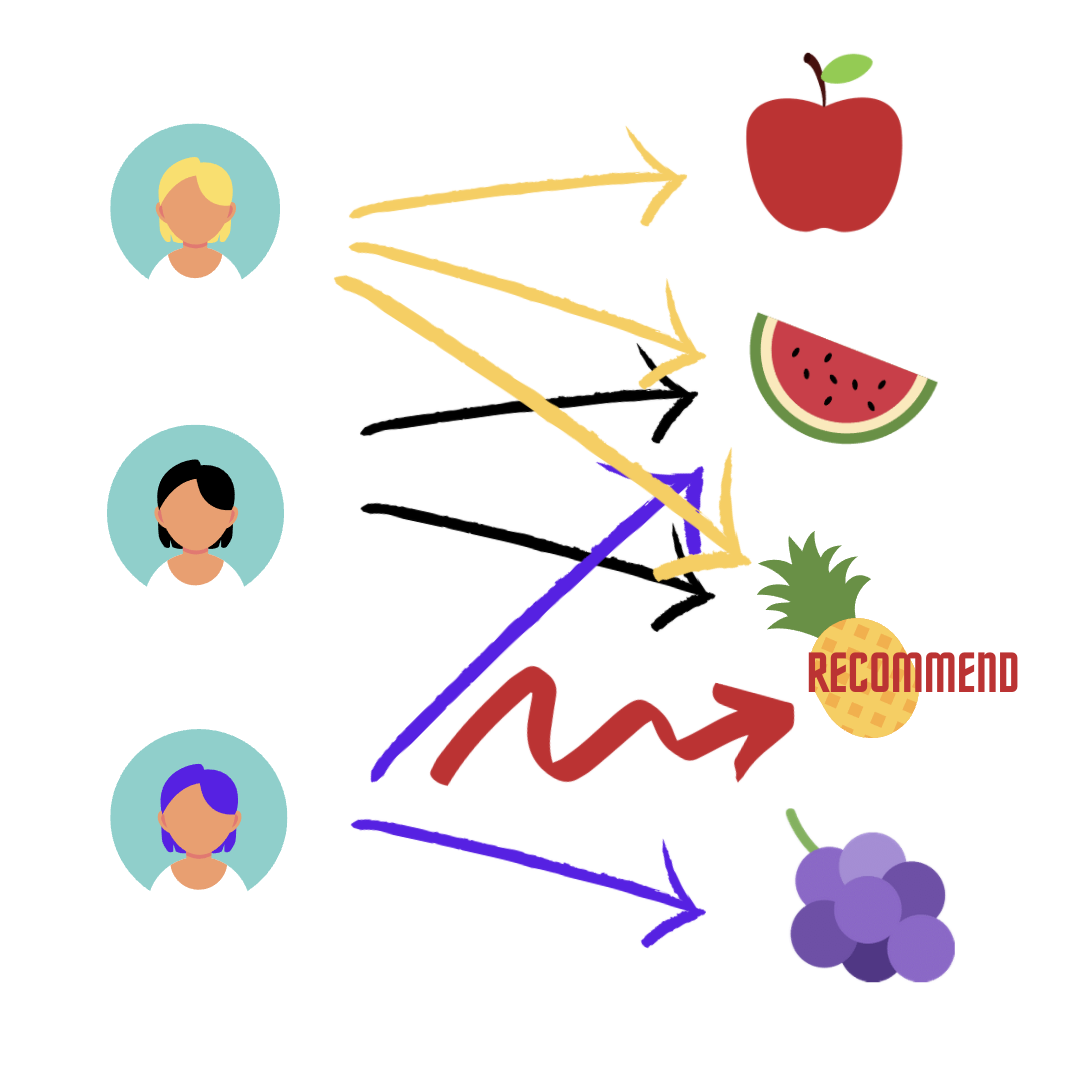

This graph illustrates how item-based collaborative filtering works using a simplified example.
* Ms. Blond likes apples, watermelons, and pineapples. Ms. Black likes watermelons and pineapples. Ms. Purple likes watermelons and grapes. 
* Because watermelons and pineapples are liked by the sampe persons, they are considered similar items.
* Since Ms. Purple likes watermelons and Ms. Purple has not been exposed to pineapples yet, the recommendation system recommends pineapples to Ms. purple. 

# Step 1: Import Python Libraries

In the first step, we will import Python libraries `pandas`, `numpy`, and `scipy.stats`. These three libraries are for data processing and calculations.

We also imported `seaborn` for visualization and `cosine_similarity` for calculating similarity scores.

In [1]:
# Data processing
import pandas as pd
import numpy as np
import scipy.stats

# Visualization
import seaborn as sns

# Similarity
from sklearn.metrics.pairwise import cosine_similarity

# Step 2: Download And Read In Data

In [2]:
# Read in data
ratings=pd.read_csv('ratings_small.csv')

# Take a look at the data
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


There are four columns in the ratings dataset, userID, movieID, rating, and timestamp.

In [3]:
# Get the dataset information
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [4]:
# Number of users
print('The ratings dataset has', ratings['userId'].nunique(), 'unique users')

# Number of movies
print('The ratings dataset has', ratings['movieId'].nunique(), 'unique movies')

# Number of ratings
print('The ratings dataset has', ratings['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(ratings['rating'].unique()))

The ratings dataset has 671 unique users
The ratings dataset has 9066 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


Next, let's read  the movies data

In [5]:
# Read in data
movies = pd.read_csv('movies_metadata.csv',low_memory=False)

In [6]:
links=pd.read_csv("links_small.csv",low_memory=False)

In [7]:
links.drop("tmdbId",axis='columns',inplace=True)
links.head(1)

,movieId,imdbId
0,1,114709


In [8]:
movies.rename(columns = {'imdb_id' : 'imdbId'}, inplace = True)

In [9]:
movies['imdbId'] =movies['imdbId'].astype(str)

In [10]:
links["imdbId"]=links["imdbId"].astype(str)

In [11]:
movies['imdbId'] =[x.strip("tt0") for x in movies["imdbId"]]

In [12]:
links["imdbId"]=links["imdbId"].astype(str)

In [13]:
movies=movies.merge(links,how="left",on="imdbId")
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdbId,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,movieId
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,2.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,3.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,4.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,5.0


Using `movieID` as the matching key, we appended movie information to the rating dataset and named it `df`. So now we have the movie tile and movie rating in the same dataset!


In [14]:
# Merge ratings and movies datasets
df = pd.merge(ratings, movies, on='movieId', how='inner')
df=df[["movieId","title","userId","rating"]]
# Take a look at the data
df.head()

,movieId,title,userId,rating
0,31,Dangerous Minds,1,2.5
1,31,Dangerous Minds,7,3.0
2,31,Dangerous Minds,31,4.0
3,31,Dangerous Minds,32,4.0
4,31,Dangerous Minds,36,3.0


# Step 3: Exploratory Data Analysis (EDA)

In step 3, we need to filter the movies and keep only those with over 100 ratings for the analysis.

To do that, we first group the movies by title, count the number of ratings, and keep only the movies with greater than 100 ratings.

The average ratings for the movies are calculated as well.

In [15]:
# Aggregate by movie
agg_ratings = df.groupby('title').agg(mean_rating = ('rating', 'mean'),
                                                number_of_ratings = ('rating', 'count')).reset_index()

# Keep the movies with over 100 ratings
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>100]

# Check the information of the dataframe
agg_ratings_GT100.info()                              

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 46 to 7845
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              140 non-null    object 
 1   mean_rating        140 non-null    float64
 2   number_of_ratings  140 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 4.4+ KB


Let's check what the most popular movies and their ratings are.

In [16]:
# Check popular movies
agg_ratings_GT100.sort_values(by='number_of_ratings', ascending=False).head()

,title,mean_rating,number_of_ratings
4535,Pulp Fiction,4.256173,324
6917,The Shawshank Redemption,4.487138,311
6926,The Silence of the Lambs,4.138158,304
5321,Star Wars,4.221649,291
6576,The Matrix,4.183398,259


Next, let's use a `jointplot` to check the correlation between the average rating and the number of ratings.

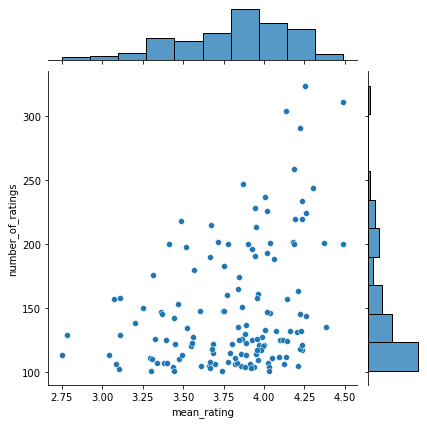

In [17]:
# Visulization
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)

In [18]:
# Merge data
df_GT100 = pd.merge(df, agg_ratings_GT100[['title']], on='title', how='inner')
df_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20737 entries, 0 to 20736
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  20737 non-null  int64  
 1   title    20737 non-null  object 
 2   userId   20737 non-null  int64  
 3   rating   20737 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 810.0+ KB


In [19]:
# Number of users
print('The ratings dataset has', df_GT100['userId'].nunique(), 'unique users')

# Number of movies
print('The ratings dataset has', df_GT100['movieId'].nunique(), 'unique movies')

# Number of ratings
print('The ratings dataset has', df_GT100['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(df_GT100['rating'].unique()))

The ratings dataset has 660 unique users
The ratings dataset has 148 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


# Step 4: Create User-Movie Matrix

In step 4, we will transform the dataset into a matrix format. The rows of the matrix are movies, and the columns of the matrix are users. The value of the matrix is the user rating of the movie if there is a rating. Otherwise, it shows 'NaN'.

In [20]:
# Create user-item matrix
matrix = df_GT100.pivot_table(index='title', columns='userId', values='rating')
matrix.head()

userId,2,3,4,5,6,7,8,9,10,11,...,662,663,664,665,666,667,668,669,670,671
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Beautiful Mind,NaN,NaN,NaN,4.5,NaN,NaN,3.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
A Bug's Life,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
A Clockwork Orange,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.5,3.0,NaN,NaN,NaN,NaN,NaN,3.0
Airplane!,NaN,NaN,5.0,NaN,NaN,NaN,4.5,NaN,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN


# Step 5: Data Normalization

In Step 5, we will normalize the data by subtracting the average rating of each movie. The cosine similarity calculated based on the normalized data is called mean-centered cosine similarity.

After normalization, the ratings less than the movie's average rating get a negative value, and the ratings more than the movie's average rating get a positive value.

In [21]:
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 0)
matrix_norm.head()

userId,2,3,4,5,6,7,8,9,10,11,...,662,663,664,665,666,667,668,669,670,671
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey,NaN,NaN,NaN,NaN,NaN,0.113821,NaN,NaN,NaN,NaN,...,NaN,NaN,0.113821,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Beautiful Mind,NaN,NaN,NaN,0.548246,NaN,NaN,-0.451754,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.048246
A Bug's Life,NaN,NaN,NaN,-0.109524,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.390476
A Clockwork Orange,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.500000,-1.000000,NaN,NaN,NaN,NaN,NaN,-1.000000
Airplane!,NaN,NaN,1.179245,NaN,NaN,NaN,0.679245,NaN,NaN,NaN,...,NaN,NaN,NaN,0.179245,NaN,NaN,NaN,NaN,NaN,NaN


# Step 6: Calculate Similarity Score

There are different ways to measure similarities. Pearson correlation and cosine similarity are two widely used methods.

we will calculate the item similarity matrix using Pearson correlation.

In [22]:
# Item similarity matrix using Pearson correlation
item_similarity = matrix_norm.T.corr()
item_similarity.head()

title,2001: A Space Odyssey,A Beautiful Mind,A Bug's Life,A Clockwork Orange,Airplane!,Aladdin,Alien,Aliens,American Beauty,American History X,...,Toy Story 2,Trainspotting,True Lies,Twelve Monkeys,Twister,Waterworld,While You Were Sleeping,Who Framed Roger Rabbit,Willy Wonka & the Chocolate Factory,X-Men
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey,1.000000,-0.027004,-0.148554,0.458892,0.117408,-0.210284,0.132329,-0.019238,0.115408,-0.271493,...,-0.200825,0.005386,0.238229,-0.111437,-0.167884,-0.007347,-0.517721,-0.136386,0.119701,0.221392
A Beautiful Mind,-0.027004,1.000000,0.565722,-0.294189,0.186625,0.327351,0.293270,0.149469,0.101538,0.349027,...,0.449628,-0.023897,0.219237,0.145244,0.382625,-0.078002,0.326740,0.285234,0.243952,-0.003053
A Bug's Life,-0.148554,0.565722,1.000000,-0.174096,0.193584,0.609588,0.253088,0.196377,0.278890,0.151588,...,0.609564,0.157159,0.230434,0.265171,0.433885,0.054671,0.326677,0.470189,0.195520,-0.019483
A Clockwork Orange,0.458892,-0.294189,-0.174096,1.000000,0.238397,-0.182278,0.141840,0.122643,0.156637,-0.176909,...,-0.207139,0.263950,-0.119566,0.091946,-0.233823,0.002454,-0.283821,-0.038087,0.107888,-0.106754
Airplane!,0.117408,0.186625,0.193584,0.238397,1.000000,0.238625,0.438908,0.409758,0.024185,-0.065880,...,0.302714,0.022341,0.081908,0.149241,-0.000827,-0.163555,-0.103313,0.298503,0.416443,-0.022869


# Step 7: Predict User's Rating For One Movie

In step 7, we will predict a user's rating for one movie. Let's use user 105 and the movie Batman Begins  as an example.

The prediction follows the process below:
1. Create a list of the movies that user 105 has watched and rated.
2. Rank the similarities between the movies user 105 rated and Batman Begins.
3. Select top n movies with highest similarity scores.
4. Calculate the predicted rating using weighted average of similarity scores and the ratings from user 105.

Now let's implement  

Firstly, we removed all the movies that have a missing rating for user 105, and sorted the movies by the ratings.

In [23]:
# Pick a user ID
picked_userid = 105

# Pick a movie
picked_movie = 'Batman Begins'

# Movies that the target user has watched
picked_userid_watched = pd.DataFrame(matrix_norm[picked_userid].dropna(axis=0, how='all')\
                          .sort_values(ascending=False))\
                          .reset_index()\
                          .rename(columns={2:'rating'})


picked_userid_watched.head(5)

,title,105
0,Beetlejuice,1.062500
1,The Lord of the Rings: The Two Towers,0.938830
2,L.A. Confidential,0.880000
3,The Lord of the Rings: The Fellowship of the Ring,0.817500
4,Jaws,0.722222


We can see that user 105th favorite movie is Beetlejuice, followed by The Lord of the Rings: The Two Towers and L.A. Confidential

Next, we get the similarity score of the movie Batman Begins with the movie user 105 has watched, and pick the top 5 movies with the highest similarity score.

In [24]:
# Similarity score of the movie American Pie with all the other movies
picked_movie_similarity_score = item_similarity[[picked_movie]].reset_index().rename(columns={'Batman Begins':'similarity_score'})

# Rank the similarities between the movies user 1 rated and American Pie.
n = 5
picked_userid_watched_similarity = pd.merge(left=picked_userid_watched, 
                                            right=picked_movie_similarity_score, 
                                            on='title', 
                                            how='inner')\
                                     .sort_values('similarity_score', ascending=False)[:5]

# Take a look at the User 1 watched movies with highest similarity
picked_userid_watched_similarity

,title,105,similarity_score
4,Jaws,0.722222,0.491388
82,Minority Report,-0.686957,0.487764
42,True Lies,-0.015152,0.486529
96,The Breakfast Club,-0.982906,0.449497
70,Braveheart,-0.445175,0.422161


After that, calculate the weighted average of ratings and similarities scores, so the movies with higher similarity scores get more weight. This weighted average is the predicted rating for Batman Begins by user 105.

In [25]:
# Calculate the predicted rating using weighted average of similarity scores and the ratings from user 1
predicted_rating = round(np.average(picked_userid_watched_similarity[picked_userid], 
                                    weights=picked_userid_watched_similarity['similarity_score']), 6)

print(f'The predicted rating for {picked_movie} by user {picked_userid} is {predicted_rating}' )

The predicted rating for Batman Begins by user 105 is -0.264105


# Step 8: Movie Recommendation

In step 8, we will create an item-item movie recommendation system following four steps:
1. Create a list of movie that the target user has not watched before.
2. Loop through the unwatched movie and create predicted scores for each movie.
3. Rank the predicted score of unwatched movie from high to low.
4. Select the top k movies as the recommendations for the target user.

The Python function below implemented the four steps. With the input of `picked_userid`, `number_of_similar_items`, and `number_of_recommendations`, we can get the top movies for the user and their corresponding ratings. Note that the ratings are normalized by extracting the average rating for the movie, so we need to add the average value back to the predicted ratings if we want the predicted ratings to be on the same scale as the original ratings.

In [26]:
# Item-based recommendation function
def item_based_rec(picked_userid=2, number_of_similar_items=5, number_of_recommendations =3):
  import operator
  # Movies that the target user has not watched
  picked_userid_unwatched = pd.DataFrame(matrix_norm[picked_userid].isna()).reset_index()
  picked_userid_unwatched = picked_userid_unwatched[picked_userid_unwatched[picked_userid]==True]['title'].values.tolist()

  # Movies that the target user has watched
  picked_userid_watched = pd.DataFrame(matrix_norm[picked_userid].dropna(axis=0, how='all')\
                            .sort_values(ascending=False))\
                            .reset_index()\
                            .rename(columns={1:'rating'})
  
  # Dictionary to save the unwatched movie and predicted rating pair
  rating_prediction ={}  

  # Loop through unwatched movies          
  for picked_movie in picked_userid_unwatched: 
    # Calculate the similarity score of the picked movie iwth other movies
    picked_movie_similarity_score = item_similarity[[picked_movie]].reset_index().rename(columns={picked_movie:'similarity_score'})
    # Rank the similarities between the picked user watched movie and the picked unwatched movie.
    picked_userid_watched_similarity = pd.merge(left=picked_userid_watched, 
                                                right=picked_movie_similarity_score, 
                                                on='title', 
                                                how='inner')\
                                        .sort_values('similarity_score', ascending=False)[:number_of_similar_items]
    # Calculate the predicted rating using weighted average of similarity scores and the ratings from user 1
    predicted_rating = round(np.average(picked_userid_watched_similarity[picked_userid], 
                                        weights=picked_userid_watched_similarity['similarity_score']), 6)
    # Save the predicted rating in the dictionary
    rating_prediction[picked_movie] = predicted_rating
    # Return the top recommended movies
  return sorted(rating_prediction.items(), key=operator.itemgetter(1), reverse=True)[:number_of_recommendations]

# Get recommendations
recommended_movie = item_based_rec(picked_userid=148, number_of_similar_items=5, number_of_recommendations =3)
recommended_movie

[('Finding Nemo', 0.938286),
 ('The Silence of the Lambs', 0.891155),
 ('Spider-Man', 0.88084)]

In [27]:
# from pickle import dump

In [28]:
# dump(matrix_norm, open('matrix_norm.pkl', 'wb'))

In [29]:
# dump(item_similarity, open('item_similarity.pkl', 'wb'))

# Summary

 we went over how to build an item-based collaborative filtering recommendation system. we learned

* What is item-based (item-item) collaborative filtering?
* How to create a user-product matrix?
* How to identify similar items?
* How to rank items for the recommendation?


# References

* [Item-Based Collaborative Filtering Lecture From Stanford](https://www.youtube.com/watch?v=FFi0iPY5fko)